In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import csv
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

d:\Languages\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Loads in the dataset
df = pd.read_parquet("merged_nominal.parquet")

#Loads in the process names
with open("summary.json", "r") as f:
  proc_dict = json.load(f)["sample_id_map"]

In [3]:
#Creates the background and signal datasets.
background = pd.concat((df[df.process_id == proc_dict["DiPhoton"]],df[df.process_id == proc_dict["TTGG"]],df[df.process_id == proc_dict["TTGamma"]],
                        df[df.process_id == proc_dict["TTJets"]],df[df.process_id == proc_dict["VBFH_M125"]],df[df.process_id == proc_dict["WGamma"]],
                        df[df.process_id == proc_dict["ZGamma"]],df[df.process_id == proc_dict["ggH_M125"]],df[df.process_id == proc_dict["ttH_M125"]],
                        df[df.process_id == proc_dict["GJets"]]), ignore_index=True, axis=0)
signal = df[df.process_id == proc_dict["GluGluToRadionToHHTo2G2Tau_M-1000"]]

In [4]:
#removed LeadPhoton_pt_mgg, ditau_dR
background_subset = background[['reco_MX_mgg', 'Diphoton_pt_mgg','ditau_pt', 'Diphoton_dPhi','dilep_leadpho_mass','lead_lepton_pt','MET_pt','SubleadPhoton_pt_mgg','Diphoton_lead_lepton_deta','weight_central']]
signal_subset = signal[['reco_MX_mgg', 'Diphoton_pt_mgg','ditau_pt', 'Diphoton_dPhi','dilep_leadpho_mass','lead_lepton_pt','MET_pt','SubleadPhoton_pt_mgg','Diphoton_lead_lepton_deta','weight_central']]

In [5]:
background_subset = background_subset.loc[(background_subset['reco_MX_mgg'] >= 0)]
background_subset = background_subset.loc[(background_subset['Diphoton_pt_mgg'] >= 0)]
background_subset = background_subset.loc[(background_subset['ditau_pt'] >= 0)]
background_subset = background_subset.loc[(background_subset['Diphoton_dPhi'] >= -4)]
background_subset = background_subset.loc[(background_subset['dilep_leadpho_mass'] >= 0)]
background_subset = background_subset.loc[(background_subset['lead_lepton_pt'] >= 0)]
background_subset = background_subset.loc[(background_subset['MET_pt'] >= 0)]
background_subset = background_subset.loc[(background_subset['SubleadPhoton_pt_mgg'] >= 0)]
background_subset = background_subset.loc[(background_subset['Diphoton_lead_lepton_deta'] >= -7)]

In [6]:
signal_subset = signal_subset.loc[(signal_subset['reco_MX_mgg'] >= 0)]
signal_subset = signal_subset.loc[(signal_subset['Diphoton_pt_mgg'] >= 0)]
signal_subset = signal_subset.loc[(signal_subset['ditau_pt'] >= 0)]
signal_subset = signal_subset.loc[(signal_subset['Diphoton_dPhi'] >= -4)]
signal_subset = signal_subset.loc[(signal_subset['dilep_leadpho_mass'] >= 0)]
signal_subset = signal_subset.loc[(signal_subset['lead_lepton_pt'] >= 0)]
signal_subset = signal_subset.loc[(signal_subset['MET_pt'] >= 0)]
signal_subset = signal_subset.loc[(signal_subset['SubleadPhoton_pt_mgg'] >= 0)]
signal_subset = signal_subset.loc[(signal_subset['Diphoton_lead_lepton_deta'] >= -7)]

In [7]:
background_subset_y = pd.DataFrame(np.zeros(len(background_subset)))
signal_subset_y = pd.DataFrame(np.ones(len(signal_subset)))

In [8]:
x = pd.concat((signal_subset,background_subset), ignore_index=True, axis=0)
y = pd.concat((signal_subset_y,background_subset_y), ignore_index=True, axis=0)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

In [10]:
X_train['weight_central']

182687    0.000185
110067   -0.000665
149204    0.000116
186354   -0.000212
32033     0.000318
            ...   
119879    0.000164
103694   -0.001443
131932    0.000128
146867   -0.000069
121958   -0.000376
Name: weight_central, Length: 133816, dtype: float32

In [11]:
X_train_weight = X_train['weight_central']
X_train.drop("weight_central", axis='columns', inplace=True)
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32).reshape(-1, 1)
x_train_weight = torch.tensor(X_train_weight.to_numpy(), dtype=torch.float32).reshape(-1, 1)

X_test_weight = X_test['weight_central']
X_test.drop("weight_central", axis='columns', inplace=True)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32).reshape(-1, 1)
x_test_weight = torch.tensor(X_test_weight.to_numpy(), dtype=torch.float32).reshape(-1, 1)

In [12]:
class SimpleClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(9, 20)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(20, 8)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(8, 1)
        self.act_output = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act_output(self.output(x))
        return x

In [13]:
model = SimpleClassifier()

In [14]:
def weightedBCELoss(input, target, weight):
  x, y, w = input, target, weight
  log = lambda x: torch.log(x*(1-1e-8) + 1e-8)
  return torch.mean(-w * (y*log(x) + (1-y)*log(1-x)))

In [15]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
 
n_epochs = 10
batch_size = 10

In [16]:
for epoch in range(n_epochs):
    for i in range(0, len(X_train), batch_size):
        Xbatch = X_train[i:i+batch_size]
        y_pred = model(Xbatch)
        ybatch = y_train[i:i+batch_size]
        loss = weightedBCELoss(y_pred, ybatch,x_train_weight[i:i+batch_size])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss -4.7233174882421736e-07
Finished epoch 1, latest loss -5.600548320217058e-06
Finished epoch 2, latest loss -7.204450866993284e-06
Finished epoch 3, latest loss -3.796908231379348e-06
Finished epoch 4, latest loss -6.100679911469342e-06
Finished epoch 5, latest loss -3.664047426354955e-06
Finished epoch 6, latest loss -1.3465664778777864e-06
Finished epoch 7, latest loss -3.360864184287493e-06
Finished epoch 8, latest loss -1.1450935062384815e-06
Finished epoch 9, latest loss -1.0659190365913673e-06


In [17]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

In [18]:
y_pred = model(X_test)
y_pred_r = y_pred.round()
accuracy = (y_pred.round() == y_test).float().mean()
print(f"Accuracy {accuracy}")

Accuracy 0.9219529032707214


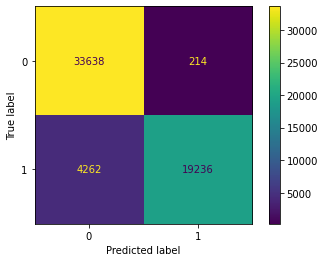

In [21]:
cm = confusion_matrix(y_test.detach().numpy(), y_pred.round().detach().numpy())
ConfusionMatrixDisplay(cm).plot()